In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 8 10:43:01 2021

@author: Bradley

FTEC5530 Individual Project
"""

'\nCreated on Sat Mar 8 10:43:01 2021\n\n@author: Bradley\n\nFTEC5530 Individual Project\n'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import ccxt
from datetime import datetime
from datetime import timedelta
import os
import talib
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False
import time
from datetime import timedelta


%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号

#### **数据获取**

In [ ]:
# =====设定参数
exchange = ccxt.binance()  # huobipro, binance, okex5，使用huobi需要增加limit=2000，XRP-USDT-200327

symbol = 'BTC/USDT'
time_interval = '1h'  # 其他可以尝试的值：'1m', '5m', '15m', '30m', '1H', '2H', '1D', '1W', '1M', '1Y'

# =====抓取数据开始结束时间
start_time = '2021-01-01 00:00:00'
end_time = '2022-03-04 00:00:00'
# end_time = pd.to_datetime(start_time) + timedelta(days=1)

# =====开始循环抓取数据
df_list = []
start_time_since = exchange.parse8601(start_time)
end_time_since = exchange.parse8601(end_time)
# 循环获取历史数据
all_kline_data = []
while True:
    # okex的v5接口比较特殊，另外处理
    if exchange.name == 'OKEX':
        params = {
            'instId': symbol,
            'bar': time_interval,
            'after': end_time_since,
            'limit': '100'
        }
        # 获取K线使
        kline_data = exchange.public_get_market_history_candles(params=params)['data']
        print(kline_data)
        if kline_data:
            end_time_since = kline_data[-1][0]  # 更新since，为下次循环做准备
            all_kline_data += kline_data
            if int(kline_data[-1][0]) < int(start_time_since):
                break
    else:
        df = exchange.fetch_ohlcv(symbol=symbol, timeframe=time_interval, since=start_time_since, limit=2000)

        # 整理数据
        df = pd.DataFrame(df, dtype=float)  # 将数据转换为dataframe
        df['candle_begin_time'] = pd.to_datetime(df[0], unit='ms')  # 整理时间
        print(df)

        # 合并数据
        df_list.append(df)

        # 新的since
        t = pd.to_datetime(df.iloc[-1][0], unit='ms')
        print(t)
        start_time_since = exchange.parse8601(str(t))

        # 判断是否挑出循环
        if t >= pd.to_datetime(end_time) or df.shape[0] <= 1:
            print('抓取完所需数据，或抓取至最新数据，完成抓取任务，退出循环')
            break

        # 抓取间隔需要暂停2s，防止抓取过于频繁
        time.sleep(2)

# 对数据进行整理
df = pd.concat(df_list, ignore_index=True)
df.rename(columns={0: 'MTS', 1: 'open', 2: 'high', 3: 'low', 4: 'close', 5: 'volume'}, inplace=True)
df['candle_begin_time'] = pd.to_datetime(df['MTS'], unit='ms') + timedelta(hours=8)
df = df[['candle_begin_time', 'open', 'high', 'low', 'close', 'volume']]

# 去重、排序
df.drop_duplicates(subset=['candle_begin_time'], keep='last', inplace=True)
df.sort_values('candle_begin_time', inplace=True)
df.reset_index(drop=True, inplace=True)
df = df[df['candle_begin_time'] < '2022-03-05']
df.to_csv("./data/hourly_data_BTC_USDT.csv", index=False, header=True)

In [27]:
# =====设定参数
exchange = ccxt.binance()  # huobipro, binance, okex5，使用huobi需要增加limit=2000，XRP-USDT-200327

symbol = 'ETH/USDT'
time_interval = '1h'  # 其他可以尝试的值：'1m', '5m', '15m', '30m', '1H', '2H', '1D', '1W', '1M', '1Y'

# =====抓取数据开始结束时间
start_time = '2021-01-01 00:00:00'
end_time = '2022-03-04 00:00:00'
# end_time = pd.to_datetime(start_time) + timedelta(days=1)

# =====开始循环抓取数据
df_list = []
start_time_since = exchange.parse8601(start_time)
end_time_since = exchange.parse8601(end_time)
# 循环获取历史数据
all_kline_data = []
while True:
    # okex的v5接口比较特殊，另外处理
    if exchange.name == 'OKEX':
        params = {
            'instId': symbol,
            'bar': time_interval,
            'after': end_time_since,
            'limit': '100'
        }
        # 获取K线使
        kline_data = exchange.public_get_market_history_candles(params=params)['data']
        print(kline_data)
        if kline_data:
            end_time_since = kline_data[-1][0]  # 更新since，为下次循环做准备
            all_kline_data += kline_data
            if int(kline_data[-1][0]) < int(start_time_since):
                break
    else:
        df = exchange.fetch_ohlcv(symbol=symbol, timeframe=time_interval, since=start_time_since, limit=2000)

        # 整理数据
        df = pd.DataFrame(df, dtype=float)  # 将数据转换为dataframe
        df['candle_begin_time'] = pd.to_datetime(df[0], unit='ms')  # 整理时间
        print(df)

        # 合并数据
        df_list.append(df)

        # 新的since
        t = pd.to_datetime(df.iloc[-1][0], unit='ms')
        print(t)
        start_time_since = exchange.parse8601(str(t))

        # 判断是否挑出循环
        if t >= pd.to_datetime(end_time) or df.shape[0] <= 1:
            print('抓取完所需数据，或抓取至最新数据，完成抓取任务，退出循环')
            break

        # 抓取间隔需要暂停2s，防止抓取过于频繁
        time.sleep(2)

# 对数据进行整理
df = pd.concat(df_list, ignore_index=True)
df.rename(columns={0: 'MTS', 1: 'open', 2: 'high', 3: 'low', 4: 'close', 5: 'volume'}, inplace=True)
df['candle_begin_time'] = pd.to_datetime(df['MTS'], unit='ms') + timedelta(hours=8)
df = df[['candle_begin_time', 'open', 'high', 'low', 'close', 'volume']]

# 去重、排序
df.drop_duplicates(subset=['candle_begin_time'], keep='last', inplace=True)
df.sort_values('candle_begin_time', inplace=True)
df.reset_index(drop=True, inplace=True)
df = df[df['candle_begin_time'] < '2022-03-05']
df.to_csv("./data/hourly_data_ETH_USDT.csv", index=False, header=True)

                0        1        2        3        4            5   candle_begin_time
0    1.609459e+12   736.42   739.00   729.33   734.07  27932.69884 2021-01-01 00:00:00
1    1.609463e+12   734.08   749.00   733.37   748.28  52336.18779 2021-01-01 01:00:00
2    1.609466e+12   748.27   749.00   742.27   744.06  33019.50100 2021-01-01 02:00:00
3    1.609470e+12   744.06   747.23   743.10   744.82  17604.80859 2021-01-01 03:00:00
4    1.609474e+12   744.87   747.09   739.30   742.29  18794.15424 2021-01-01 04:00:00
..            ...      ...      ...      ...      ...          ...                 ...
995  1.613045e+12  1763.36  1790.31  1760.00  1779.58  33566.79049 2021-02-11 12:00:00
996  1.613048e+12  1779.41  1819.00  1778.81  1789.42  82515.11930 2021-02-11 13:00:00
997  1.613052e+12  1789.41  1805.00  1781.79  1796.55  38766.72095 2021-02-11 14:00:00
998  1.613056e+12  1796.55  1805.89  1786.73  1796.17  34208.43983 2021-02-11 15:00:00
999  1.613059e+12  1796.40  1810.00  1787.9

In [29]:
# =====设定参数
exchange = ccxt.binance()  # huobipro, binance, okex5，使用huobi需要增加limit=2000，XRP-USDT-200327

symbol = 'BTC/USDT'
time_interval = '1d'   # 其他可以尝试的值：'1m', '5m', '15m', '30m', '1h', '2h', '1d', '1w', '1M', '1y'

# =====抓取数据开始结束时间
# 只能最早到2017年8月17日，因为那个时候币安才开始创办
start_time = '2010-01-01 00:00:00'
end_time = '2022-03-04 00:00:00'
# end_time = pd.to_datetime(start_time) + timedelta(days=1)

# =====开始循环抓取数据
df_list = []
start_time_since = exchange.parse8601(start_time)
end_time_since = exchange.parse8601(end_time)
# 循环获取历史数据
all_kline_data = []
while True:
    # okex的v5接口比较特殊，另外处理
    if exchange.name == 'OKEX':
        params = {
            'instId': symbol,
            'bar': time_interval,
            'after': end_time_since,
            'limit': '100'
        }
        # 获取K线使
        kline_data = exchange.public_get_market_history_candles(params=params)['data']
        print(kline_data)
        if kline_data:
            end_time_since = kline_data[-1][0]  # 更新since，为下次循环做准备
            all_kline_data += kline_data
            if int(kline_data[-1][0]) < int(start_time_since):
                break
    else:
        df = exchange.fetch_ohlcv(symbol=symbol, timeframe=time_interval, since=start_time_since, limit=2000)

        # 整理数据
        df = pd.DataFrame(df, dtype=float)  # 将数据转换为dataframe
        df['candle_begin_time'] = pd.to_datetime(df[0], unit='ms')  # 整理时间
        print(df)

        # 合并数据
        df_list.append(df)

        # 新的since
        t = pd.to_datetime(df.iloc[-1][0], unit='ms')
        print(t)
        start_time_since = exchange.parse8601(str(t))

        # 判断是否挑出循环
        if t >= pd.to_datetime(end_time) or df.shape[0] <= 1:
            print('抓取完所需数据，或抓取至最新数据，完成抓取任务，退出循环')
            break

        # 抓取间隔需要暂停2s，防止抓取过于频繁
        time.sleep(2)

# 对数据进行整理
df = pd.concat(df_list, ignore_index=True)
df.rename(columns={0: 'MTS', 1: 'open', 2: 'high', 3: 'low', 4: 'close', 5: 'volume'}, inplace=True)
df['candle_begin_time'] = pd.to_datetime(df['MTS'], unit='ms') + timedelta(hours=8)
df = df[['candle_begin_time', 'open', 'high', 'low', 'close', 'volume']]

# 去重、排序
df.drop_duplicates(subset=['candle_begin_time'], keep='last', inplace=True)
df.sort_values('candle_begin_time', inplace=True)
df.reset_index(drop=True, inplace=True)
df = df[df['candle_begin_time'] < '2022-03-05']
df.to_csv("./data/daily_data_BTC_USDT.csv", index=False, header=True)

                0        1         2        3        4              5 candle_begin_time
0    1.502928e+12  4261.48   4485.39  4200.74  4285.08     795.150377        2017-08-17
1    1.503014e+12  4285.08   4371.52  3938.77  4108.37    1199.888264        2017-08-18
2    1.503101e+12  4108.37   4184.69  3850.00  4139.98     381.309763        2017-08-19
3    1.503187e+12  4120.98   4211.08  4032.62  4086.29     467.083022        2017-08-20
4    1.503274e+12  4069.13   4119.62  3911.79  4016.00     691.743060        2017-08-21
..            ...      ...       ...      ...      ...            ...               ...
995  1.588896e+12  9986.30  10035.96  9705.00  9800.01  100683.796400        2020-05-08
996  1.588982e+12  9800.02   9914.25  9520.00  9539.40   81950.679567        2020-05-09
997  1.589069e+12  9539.10   9574.83  8117.00  8722.77  183865.182028        2020-05-10
998  1.589155e+12  8722.77   9168.00  8200.00  8561.52  168807.251832        2020-05-11
999  1.589242e+12  8562.04   897

In [31]:
# =====设定参数
exchange = ccxt.binance()  # huobipro, binance, okex5，使用huobi需要增加limit=2000，XRP-USDT-200327

symbol = 'ETH/USDT'
time_interval = '1d'   # 其他可以尝试的值：'1m', '5m', '15m', '30m', '1h', '2h', '1d', '1w', '1M', '1y'

# =====抓取数据开始结束时间
# 只能最早到2017年8月17日，因为那个时候币安才开始创办
start_time = '2010-01-01 00:00:00'
end_time = '2022-03-04 00:00:00'
# end_time = pd.to_datetime(start_time) + timedelta(days=1)

# =====开始循环抓取数据
df_list = []
start_time_since = exchange.parse8601(start_time)
end_time_since = exchange.parse8601(end_time)
# 循环获取历史数据
all_kline_data = []
while True:
    # okex的v5接口比较特殊，另外处理
    if exchange.name == 'OKEX':
        params = {
            'instId': symbol,
            'bar': time_interval,
            'after': end_time_since,
            'limit': '100'
        }
        # 获取K线使
        kline_data = exchange.public_get_market_history_candles(params=params)['data']
        print(kline_data)
        if kline_data:
            end_time_since = kline_data[-1][0]  # 更新since，为下次循环做准备
            all_kline_data += kline_data
            if int(kline_data[-1][0]) < int(start_time_since):
                break
    else:
        df = exchange.fetch_ohlcv(symbol=symbol, timeframe=time_interval, since=start_time_since, limit=2000)

        # 整理数据
        df = pd.DataFrame(df, dtype=float)  # 将数据转换为dataframe
        df['candle_begin_time'] = pd.to_datetime(df[0], unit='ms')  # 整理时间
        print(df)

        # 合并数据
        df_list.append(df)

        # 新的since
        t = pd.to_datetime(df.iloc[-1][0], unit='ms')
        print(t)
        start_time_since = exchange.parse8601(str(t))

        # 判断是否挑出循环
        if t >= pd.to_datetime(end_time) or df.shape[0] <= 1:
            print('抓取完所需数据，或抓取至最新数据，完成抓取任务，退出循环')
            break

        # 抓取间隔需要暂停2s，防止抓取过于频繁
        time.sleep(2)

# 对数据进行整理
df = pd.concat(df_list, ignore_index=True)
df.rename(columns={0: 'MTS', 1: 'open', 2: 'high', 3: 'low', 4: 'close', 5: 'volume'}, inplace=True)
df['candle_begin_time'] = pd.to_datetime(df['MTS'], unit='ms') + timedelta(hours=8)
df = df[['candle_begin_time', 'open', 'high', 'low', 'close', 'volume']]

# 去重、排序
df.drop_duplicates(subset=['candle_begin_time'], keep='last', inplace=True)
df.sort_values('candle_begin_time', inplace=True)
df.reset_index(drop=True, inplace=True)
df = df[df['candle_begin_time'] < '2022-03-05']
df.to_csv("./data/daily_data_ETH_USDT.csv", index=False, header=True)

                0       1       2       3       4             5 candle_begin_time
0    1.502928e+12  301.13  312.18  298.00  302.00  7.030710e+03        2017-08-17
1    1.503014e+12  302.00  311.79  283.94  293.96  9.537846e+03        2017-08-18
2    1.503101e+12  293.31  299.90  278.00  290.91  2.146198e+03        2017-08-19
3    1.503187e+12  289.41  300.53  282.85  299.10  2.510139e+03        2017-08-20
4    1.503274e+12  299.10  346.52  294.60  323.29  5.219445e+03        2017-08-21
..            ...     ...     ...     ...     ...           ...               ...
995  1.588896e+12  212.01  216.61  206.90  211.31  9.179082e+05        2020-05-08
996  1.588982e+12  211.32  214.60  208.40  210.07  5.878720e+05        2020-05-09
997  1.589069e+12  210.09  210.18  179.59  187.54  1.473226e+06        2020-05-10
998  1.589155e+12  187.62  193.50  176.00  185.73  1.093300e+06        2020-05-11
999  1.589242e+12  185.80  192.24  185.48  189.76  6.697558e+05        2020-05-12

[1000 rows x 7 

#### **回测**

In [89]:
def simple_moving_average_signal(df, para=[20, 120]) -> pd.DataFrame:
    """
    简单的移动平均线策略，只能做多。
    当短期均线上穿长期均线的时候，做多，当短期均线下穿长期均线的时候，平仓
    :param df:
    :param para: ma_short, ma_long
    :return: 最终输出的df中，新增字段：signal，记录发出的交易信号
    """
    ma_short, ma_long = para[0], para[1]  

    # ===计算均线：所有的指标，都要使用复权价格进行计算
    df['ma_short'] = df['close'].ewm(ma_short, min_periods=1).mean()
    df['ma_long'] = df['close'].ewm(ma_long, min_periods=1).mean()

    # ===找出做多信号
    condition1 = df['ma_short'] > df['ma_long']  # 短期均线 > 长期均线
    condition2 = df['ma_short'].shift(1) <= df['ma_long'].shift(1)  # 上一周期的短期均线 <= 长期均线
    df.loc[condition1 & condition2, 'signal'] = 1  # 将产生做多信号的那根K线的signal设置为1，1代表做多

    # ===找出做多平仓信号
    condition1 = df['ma_short'] < df['ma_long']  # 短期均线 < 长期均线
    condition2 = df['ma_short'].shift(1) >= df['ma_long'].shift(1)  # 上一周期的短期均线 >= 长期均线
    df.loc[condition1 & condition2, 'signal'] = -1  # 将产生平仓信号当天的signal设置为0，0代表平仓

    # ===删除无关中间变量
    df.drop(['ma_short', 'ma_long'], axis=1, inplace=True)
    return df

# 简单移动平均线策略参数，类似机器学习，我们对parameter做一个循环，长短均线就是两个参数，循环看哪组参数最优
# 本函数可得到所有的长短均线参数组合
def simple_moving_average_para_list(ma_short=range(10, 200, 10), ma_long=range(10, 300, 10)) -> list:
    para_list = []
    for short in ma_short:
        for long in ma_long:
            if short >= long:
                continue
            else:
                para_list.append([short, long])
    return para_list

In [93]:
def macd_signal(df, para=[12, 26, 9]) -> pd.DataFrame:
    """
    简单的移动平均线策略，只能做多。
    当短期均线上穿长期均线的时候，做多，当短期均线下穿长期均线的时候，平仓
    :param df:
    :param para: ma_short, ma_long
    :return: 最终输出的df中，新增字段：signal，记录发出的交易信号
    """
    short, long, sig = para[0], para[1], para[2]


    # ===计算均线：所有的指标，都要使用复权价格进行计算
    df['ma_short'] = df['close'].ewm(short, min_periods=1).mean()
    df['ma_long'] = df['close'].ewm(long, min_periods=1).mean()

    # ===找出做多信号
    condition1 = df['ma_short'] > df['ma_long']  # 短期均线 > 长期均线
    condition2 = df['ma_short'].shift(1) <= df['ma_long'].shift(1)  # 上一周期的短期均线 <= 长期均线
    df.loc[condition1 & condition2, 'signal'] = 1  # 将产生做多信号的那根K线的signal设置为1，1代表做多

    # ===找出做多平仓信号
    condition1 = df['ma_short'] < df['ma_long']  # 短期均线 < 长期均线
    condition2 = df['ma_short'].shift(1) >= df['ma_long'].shift(1)  # 上一周期的短期均线 >= 长期均线
    df.loc[condition1 & condition2, 'signal'] = -1  # 将产生平仓信号当天的signal设置为0，0代表平仓

    # ===删除无关中间变量
    df.drop(['ma_short', 'ma_long'], axis=1, inplace=True)
    return df

# 简单移动平均线策略参数，类似机器学习，我们对parameter做一个循环，长短均线就是两个参数，循环看哪组参数最优
# 本函数可得到所有的长短均线参数组合
def macd_para_list(e_short, e_long, sig) -> list:
    para_list = []
    for sigma in sig:
        for short in e_short:
            for long in e_long:
                if short >= long:
                    continue
                else:
                    para_list.append([short, long, sig])
    return para_list

In [90]:
# 计算持仓信息
# 由交易信号产生实际持仓
def position_for_OKEx_future(df):
    """
    根据signal产生实际持仓。考虑各种不能买入卖出的情况。
    所有的交易都是发生在产生信号的K线的结束时
    :param df:
    :return:
    """

    # ===由signal计算出实际的每天持有仓位
    # 在产生signal的k线结束的时候，进行买入
    df['signal'].fillna(method='ffill', inplace=True)
    df['signal'].fillna(value=0, inplace=True)  # 将初始行数的signal补全为0
    df['pos'] = df['signal'].shift()
    df['pos'].fillna(value=0, inplace=True)  # 将初始行数的pos补全为0

    # ===对无法买卖的时候做出相关处理
    # 例如：下午4点清算，无法交易；股票、期货当天涨跌停的时候无法买入；股票的t+1交易制度等等。
    # 当前周期持仓无法变动的K线
    condition = (df['candle_begin_time'].dt.hour == 16) & (df['candle_begin_time'].dt.minute == 0)
    df.loc[condition, 'pos'] = None
    # pos为空的时，不能买卖，只能和前一周期保持一致。
    df['pos'].fillna(method='ffill', inplace=True)

    # 在实际操作中，不一定会直接跳过4点这个周期，而是会停止N分钟下单。此时可以注释掉上面的代码。

    # ===将数据存入hdf文件中
    # 删除无关中间变量
    df.drop(['signal'], axis=1, inplace=True)

    return df

# 计算资金曲线
# =====计算资金曲线
# okex交割合约（usdt本位）资金曲线
def equity_curve_for_OKEx_USDT_future_next_open(df, slippage=1 / 1000, c_rate=5 / 10000, leverage_rate=3, face_value=0.01,
                                                min_margin_ratio=1/100):
    """
    okex交割合约（usdt本位）资金曲线
    开仓价格是下根K线的开盘价，可以是其他的形式
    相比之前杠杆交易的资金曲线函数，逻辑简单很多：手续费的处理、爆仓的处理等。
    在策略中增加滑点的。滑点的处理和手续费是不同的。
    :param df:
    :param slippage:  滑点 ，可以用百分比，也可以用固定值。建议币圈用百分比，股票用固定值
    :param c_rate:  手续费，commission fees，默认为万分之5。不同市场手续费的收取方法不同，对结果有影响。比如和股票就不一样。
    :param leverage_rate:  杠杆倍数
    :param face_value:  一张合约的面值，0.01BTC
    :param min_margin_ratio: 最低保证金率，低于就会爆仓
    :return:
    """
    # =====下根k线开盘价
    df['next_open'] = df['open'].shift(-1)  # 下根K线的开盘价
    df['next_open'].fillna(value=df['close'], inplace=True)

    # =====找出开仓、平仓的k线
    condition1 = df['pos'] != 0  # 当前周期不为空仓
    condition2 = df['pos'] != df['pos'].shift(1)  # 当前周期和上个周期持仓方向不一样。
    open_pos_condition = condition1 & condition2

    condition1 = df['pos'] != 0  # 当前周期不为空仓
    condition2 = df['pos'] != df['pos'].shift(-1)  # 当前周期和下个周期持仓方向不一样。
    close_pos_condition = condition1 & condition2

    # =====对每次交易进行分组
    df.loc[open_pos_condition, 'start_time'] = df['candle_begin_time']
    df['start_time'].fillna(method='ffill', inplace=True)
    df.loc[df['pos'] == 0, 'start_time'] = pd.NaT

    # =====开始计算资金曲线
    initial_cash = 10000  # 初始资金，默认为10000元
    # ===在开仓时
    # 在open_pos_condition的K线，以开盘价计算买入合约的数量。（当资金量大的时候，可以用5分钟均价）
    df.loc[open_pos_condition, 'contract_num'] = initial_cash * leverage_rate / (face_value * df['open'])
    df['contract_num'] = np.floor(df['contract_num'])  # 对合约张数向下取整
    # 开仓价格：理论开盘价加上相应滑点
    df.loc[open_pos_condition, 'open_pos_price'] = df['open'] * (1 + slippage * df['pos'])
    # 开仓之后剩余的钱，扣除手续费
    df['cash'] = initial_cash - df['open_pos_price'] * face_value * df['contract_num'] * c_rate  # 即保证金

    # ===开仓之后每根K线结束时
    # 买入之后cash，contract_num，open_pos_price不再发生变动
    for _ in ['contract_num', 'open_pos_price', 'cash']:
        df[_].fillna(method='ffill', inplace=True)
    df.loc[df['pos'] == 0, ['contract_num', 'open_pos_price', 'cash']] = None

    # ===在平仓时
    # 平仓价格
    df.loc[close_pos_condition, 'close_pos_price'] = df['next_open'] * (1 - slippage * df['pos'])
    # 平仓之后剩余的钱，扣除手续费
    df.loc[close_pos_condition, 'close_pos_fee'] = df['close_pos_price'] * face_value * df['contract_num'] * c_rate

    # ===计算利润
    # 开仓至今持仓盈亏
    df['profit'] = face_value * df['contract_num'] * (df['close'] - df['open_pos_price']) * df['pos']
    # 平仓时理论额外处理
    df.loc[close_pos_condition, 'profit'] = face_value * df['contract_num'] * (
            df['close_pos_price'] - df['open_pos_price']) * df['pos']
    # 账户净值
    df['net_value'] = df['cash'] + df['profit']

    # ===计算爆仓
    # 至今持仓盈亏最小值
    df.loc[df['pos'] == 1, 'price_min'] = df['low']
    df.loc[df['pos'] == -1, 'price_min'] = df['high']
    df['profit_min'] = face_value * df['contract_num'] * (df['price_min'] - df['open_pos_price']) * df['pos']
    # 账户净值最小值
    df['net_value_min'] = df['cash'] + df['profit_min']
    # 计算保证金率
    df['margin_ratio'] = df['net_value_min'] / (face_value * df['contract_num'] * df['price_min'])
    # 计算是否爆仓
    df.loc[df['margin_ratio'] <= (min_margin_ratio + c_rate), '是否爆仓'] = 1

    # ===平仓时扣除手续费
    df.loc[close_pos_condition, 'net_value'] -= df['close_pos_fee']
    # 应对偶然情况：下一根K线开盘价格价格突变，在平仓的时候爆仓。此处处理有省略，不够精确。
    df.loc[close_pos_condition & (df['net_value'] < 0), '是否爆仓'] = 1


    # =====计算资金曲线
    df['equity_change'] = df['net_value'].pct_change()
    df.loc[open_pos_condition, 'equity_change'] = df.loc[open_pos_condition, 'net_value'] / initial_cash - 1  # 开仓日的收益率
    df['equity_change'].fillna(value=0, inplace=True)
    df['equity_curve'] = (1 + df['equity_change']).cumprod()

    # =====删除不必要的数据，并存储
    df.drop(['next_open', 'contract_num', 'open_pos_price', 'cash', 'close_pos_price', 'close_pos_fee',
             'profit', 'net_value', 'price_min', 'profit_min', 'net_value_min', 'margin_ratio', '是否爆仓'],
            axis=1, inplace=True)

    return df

In [76]:
df = pd.read_csv("./data/hourly_data_BTC_USDT.csv")
df

,candle_begin_time,open,high,low,close,volume
0,2021-01-01 08:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
1,2021-01-01 09:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2,2021-01-01 10:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
3,2021-01-01 11:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
4,2021-01-01 12:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803
...,...,...,...,...,...,...
10246,2022-03-04 19:00:00,41676.56,41904.88,41570.97,41662.07,1326.240830
10247,2022-03-04 20:00:00,41662.06,41762.43,41340.23,41511.29,1734.155490
10248,2022-03-04 21:00:00,41511.30,41833.00,41244.37,41315.76,2407.415790
10249,2022-03-04 22:00:00,41315.75,41536.70,40590.42,41106.91,5405.073360


In [91]:
# 手工设定策略参数
symbol = 'BTC-USDT_5m'

# face_value = 0.01  # btc是0.01，不同的币种要进行不同的替换
# c_rate = 5 / 10000  # 手续费，commission fees，默认为万分之5。不同市场手续费的收取方法不同，对结果有影响。比如和股票就不一样。
# slippage = 1 / 1000  # 滑点 ，可以用百分比，也可以用固定值。建议币圈用百分比，股票用固定值
# leverage_rate = 3
# min_margin_ratio = 1 / 100  # 最低保证金率，低于就会爆仓
# drop_days = 10  # 币种刚刚上线10天内不交易


# face_value = 0.01  # btc是0.01，不同的币种要进行不同的替换
# c_rate = 0  # 手续费，commission fees，默认为万分之5。不同市场手续费的收取方法不同，对结果有影响。比如和股票就不一样。
# slippage = 0  # 滑点 ，可以用百分比，也可以用固定值。建议币圈用百分比，股票用固定值
# leverage_rate = 1
# min_margin_ratio = 1 / 100  # 最低保证金率，低于就会爆仓
# drop_days = 0  # 币种刚刚上线10天内不交易

face_value = 0.0001  # btc是0.01，不同的币种要进行不同的替换
c_rate = 0  # 手续费，commission fees，默认为万分之5。不同市场手续费的收取方法不同，对结果有影响。比如和股票就不一样。
slippage = 0  # 滑点 ，可以用百分比，也可以用固定值。建议币圈用百分比，股票用固定值
leverage_rate = 1
min_margin_ratio = 0  # 最低保证金率，低于就会爆仓
drop_days = 0  # 币种刚刚上线10天内不交易

# =====读入数据
df = pd.read_csv("./data/hourly_data_BTC_USDT.csv")
# 任何原始数据读入都进行一下排序、去重，以防万一
df.sort_values(by=['candle_begin_time'], inplace=True)
df.drop_duplicates(subset=['candle_begin_time'], inplace=True)
df.reset_index(inplace=True, drop=True)
df['candle_begin_time'] = pd.to_datetime(df['candle_begin_time'])



In [92]:
# =====获取策略参数组合
# para_list = signal_simple_bolling_para_list()
para_list = simple_moving_average_para_list(ma_short=range(3, 50, 1), ma_long=range(3, 50, 1))
# =====遍历参数
rtn = pd.DataFrame()
for para in para_list:
    _df = df.copy()
    # 计算交易信号
    # _df = signal_simple_bolling(_df, para=para)
    _df = simple_moving_average_signal(_df, para=para)
    # 计算实际持仓
    _df = position_for_OKEx_future(_df)
    # 计算资金曲线
    _df = equity_curve_for_OKEx_USDT_future_next_open(_df, slippage=slippage, c_rate=c_rate, leverage_rate=leverage_rate,
                                                      face_value=face_value, min_margin_ratio=min_margin_ratio)
    # 计算收益
    r = _df.iloc[-1]['equity_curve']
    # print(para, '策略最终收益：', r)
    rtn.loc[str(para), 'equity_curve'] = r

# =====输出
rtn.sort_values(by='equity_curve', ascending=False, inplace=True)
print(rtn)

          equity_curve
[3, 34]       3.236957
[3, 33]       3.196086
[3, 36]       3.147983
[3, 32]       3.059786
[3, 35]       2.879097
...                ...
[40, 49]      0.499584
[44, 46]      0.490080
[42, 48]      0.481032
[43, 47]      0.480510
[41, 49]      0.478371

[1081 rows x 1 columns]


In [94]:
# =====获取策略参数组合
# para_list = signal_simple_bolling_para_list()
para_list = macd_para_list(range(3, 50, 1), range(3, 50, 1), range(5, 26, 1))
# =====遍历参数
rtn = pd.DataFrame()
for para in para_list:
    _df = df.copy()
    # 计算交易信号
    # _df = signal_simple_bolling(_df, para=para)
    _df = simple_moving_average_signal(_df, para=para)
    # 计算实际持仓
    _df = position_for_OKEx_future(_df)
    # 计算资金曲线
    _df = equity_curve_for_OKEx_USDT_future_next_open(_df, slippage=slippage, c_rate=c_rate, leverage_rate=leverage_rate,
                                                      face_value=face_value, min_margin_ratio=min_margin_ratio)
    # 计算收益
    r = _df.iloc[-1]['equity_curve']
    # print(para, '策略最终收益：', r)
    rtn.loc[str(para), 'equity_curve'] = r

# =====输出
rtn.sort_values(by='equity_curve', ascending=False, inplace=True)
print(rtn)

                        equity_curve
[3, 34, range(5, 26)]       3.236957
[3, 33, range(5, 26)]       3.196086
[3, 36, range(5, 26)]       3.147983
[3, 32, range(5, 26)]       3.059786
[3, 35, range(5, 26)]       2.879097
...                              ...
[40, 49, range(5, 26)]      0.499584
[44, 46, range(5, 26)]      0.490080
[42, 48, range(5, 26)]      0.481032
[43, 47, range(5, 26)]      0.480510
[41, 49, range(5, 26)]      0.478371

[1081 rows x 1 columns]


In [ ]:
para_best = eval(rtn.index[0])
para_best

[10, 30]

In [12]:
_df = df.copy()
# 计算交易信号
# _df = signal_simple_bolling(_df, para=para)
# _df = simple_moving_average_signal(_df, para=para_best)
_df = simple_moving_average_signal(_df, para=(5,30))
# 计算实际持仓
_df = position_for_OKEx_future(_df)
# 计算资金曲线
_df = equity_curve_for_OKEx_USDT_future_next_open(_df, slippage=slippage, c_rate=c_rate, leverage_rate=leverage_rate,
                                                    face_value=face_value, min_margin_ratio=min_margin_ratio)
_df.tail(5)

,candle_begin_time,open,high,low,close,volume,pos,start_time,equity_change,equity_curve
1656,2022-02-28 08:00:00,37699.08,44225.84,37450.17,43160.00,73945.63858,-1.0,2022-02-19 08:00:00,-0.129175,18.400202
1657,2022-03-01 08:00:00,43160.00,44949.00,42809.98,44421.20,61743.09873,-1.0,2022-02-19 08:00:00,-0.034258,17.769843
1658,2022-03-02 08:00:00,44421.20,45400.00,43334.09,43892.98,57782.65081,1.0,2022-03-02 08:00:00,-0.011621,17.563342
1659,2022-03-03 08:00:00,43892.99,44101.12,41832.28,42454.00,50940.61021,1.0,2022-03-02 08:00:00,-0.032030,17.000792
1660,2022-03-04 08:00:00,42454.00,42527.30,38550.00,39148.66,61964.68498,1.0,2022-03-02 08:00:00,-0.076007,15.708614


In [95]:
_df.head()

,candle_begin_time,open,high,low,close,volume,pos,start_time,equity_change,equity_curve
1,2021-01-01 09:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,0.0,NaT,0.0,1.0
2,2021-01-01 10:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,0.0,NaT,0.0,1.0
3,2021-01-01 11:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077,0.0,NaT,0.0,1.0
4,2021-01-01 12:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803,0.0,NaT,0.0,1.0
5,2021-01-01 13:00:00,29220.31,29235.28,29084.11,29187.01,1469.956262,0.0,NaT,0.0,1.0


In [96]:
data = pd.read_csv("./data/hourly_data_BTC_USDT.csv")
data['return'] = data['close'].pct_change()
data['candle_begin_time'] = pd.to_datetime(data['candle_begin_time'])
data.set_index('candle_begin_time', inplace=True)
data['cum_return'] = (1+data['return']).cumprod()
data

,open,high,low,close,volume,return,cum_return
candle_begin_time,,,,,,,
2021-01-01 08:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445,NaN,NaN
2021-01-01 09:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,0.014308,1.014308
2021-01-01 10:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,-0.007322,1.006881
2021-01-01 11:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077,0.002869,1.009770
2021-01-01 12:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803,-0.001984,1.007766
...,...,...,...,...,...,...,...
2022-03-04 19:00:00,41676.56,41904.88,41570.97,41662.07,1326.240830,-0.000348,1.436864
2022-03-04 20:00:00,41662.06,41762.43,41340.23,41511.29,1734.155490,-0.003619,1.431664
2022-03-04 21:00:00,41511.30,41833.00,41244.37,41315.76,2407.415790,-0.004710,1.424921


In [97]:
strategy = _df.copy()
strategy.set_index("candle_begin_time", inplace=True)
strategy

,open,high,low,close,volume,pos,start_time,equity_change,equity_curve
candle_begin_time,,,,,,,,,
2021-01-01 09:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,0.0,NaT,0.000000,1.000000
2021-01-01 10:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,0.0,NaT,0.000000,1.000000
2021-01-01 11:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077,0.0,NaT,0.000000,1.000000
2021-01-01 12:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803,0.0,NaT,0.000000,1.000000
2021-01-01 13:00:00,29220.31,29235.28,29084.11,29187.01,1469.956262,0.0,NaT,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
2022-03-04 19:00:00,41676.56,41904.88,41570.97,41662.07,1326.240830,1.0,2022-02-28 09:00:00,-0.000341,2.283616
2022-03-04 20:00:00,41662.06,41762.43,41340.23,41511.29,1734.155490,1.0,2022-02-28 09:00:00,-0.003544,2.275524
2022-03-04 21:00:00,41511.30,41833.00,41244.37,41315.76,2407.415790,1.0,2022-02-28 09:00:00,-0.004612,2.265029


In [98]:
result = pd.merge(strategy['equity_curve'], data['cum_return'], on='candle_begin_time')
result.columns = ['strategy', 'benchmark']
result

,strategy,benchmark
candle_begin_time,,
2021-01-01 09:00:00,1.000000,1.014308
2021-01-01 10:00:00,1.000000,1.006881
2021-01-01 11:00:00,1.000000,1.009770
2021-01-01 12:00:00,1.000000,1.007766
2021-01-01 13:00:00,1.000000,1.006618
...,...,...
2022-03-04 19:00:00,2.283616,1.436864
2022-03-04 20:00:00,2.275524,1.431664
2022-03-04 21:00:00,2.265029,1.424921


<AxesSubplot:xlabel='candle_begin_time'>

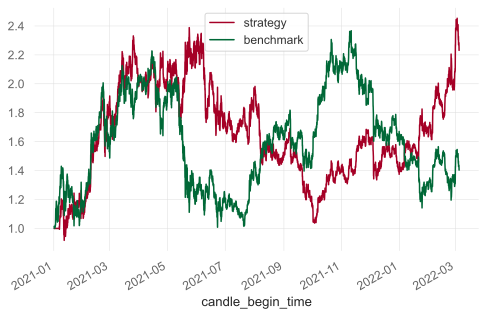

In [99]:
result[['strategy', 'benchmark']].plot(kind='line', grid=True, colormap='RdYlGn',figsize=(8,5), legend=True)

In [100]:
result

,strategy,benchmark
candle_begin_time,,
2021-01-01 09:00:00,1.000000,1.014308
2021-01-01 10:00:00,1.000000,1.006881
2021-01-01 11:00:00,1.000000,1.009770
2021-01-01 12:00:00,1.000000,1.007766
2021-01-01 13:00:00,1.000000,1.006618
...,...,...
2022-03-04 19:00:00,2.283616,1.436864
2022-03-04 20:00:00,2.275524,1.431664
2022-03-04 21:00:00,2.265029,1.424921


In [101]:
import quantstats as qs
qs.reports.html(result['strategy'],benchmark=result['benchmark'], output="rotation.html")


In [16]:
data = pd.read_csv("./data/daily_data_BTC_USDT.csv")
data['date'] = pd.to_datetime(data['candle_begin_time'].str[:10])
data.drop(['candle_begin_time'], axis=1, inplace=True)
# data.to_csv("./data/daily_BTC-USDT.csv", index=False, header=True)
data

,open,high,low,close,volume,date
0,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17
1,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18
2,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19
3,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20
4,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21
...,...,...,...,...,...,...
1656,37699.08,44225.84,37450.17,43160.00,73945.638580,2022-02-28
1657,43160.00,44949.00,42809.98,44421.20,61743.098730,2022-03-01
1658,44421.20,45400.00,43334.09,43892.98,57782.650810,2022-03-02
1659,43892.99,44101.12,41832.28,42454.00,50940.610210,2022-03-03


In [8]:
data = pd.read_csv("./data/daily_data_ETH_USDT.csv")
data['date'] = pd.to_datetime(data['candle_begin_time'].str[:10])
data.drop(['candle_begin_time'], axis=1, inplace=True)
data.to_csv("./data/daily_ETH-USDT.csv", index=False, header=True)

In [86]:
data = pd.read_csv("./data/hourly_data_BTC_USDT.csv")
data['date'] = pd.to_datetime(data['candle_begin_time'].str[:10], format='%Y-%m-%d')
data['time'] = data['candle_begin_time'].str[11:]
data.drop(['candle_begin_time'], axis=1, inplace=True)
data.to_csv("./data/hourly_BTC-USDT.csv", index=False, header=True)
data

,open,high,low,close,volume,date,time
0,28923.63,29031.34,28690.17,28995.13,2311.811445,2021-01-01,08:00:00
1,28995.13,29470.00,28960.35,29409.99,5403.068471,2021-01-01,09:00:00
2,29410.00,29465.26,29120.03,29194.65,2384.231560,2021-01-01,10:00:00
3,29195.25,29367.00,29150.02,29278.40,1461.345077,2021-01-01,11:00:00
4,29278.41,29395.00,29029.40,29220.31,2038.046803,2021-01-01,12:00:00
...,...,...,...,...,...,...,...
10246,41676.56,41904.88,41570.97,41662.07,1326.240830,2022-03-04,19:00:00
10247,41662.06,41762.43,41340.23,41511.29,1734.155490,2022-03-04,20:00:00
10248,41511.30,41833.00,41244.37,41315.76,2407.415790,2022-03-04,21:00:00
10249,41315.75,41536.70,40590.42,41106.91,5405.073360,2022-03-04,22:00:00


In [15]:
data = pd.read_csv("./data/hourly_data_ETH_USDT.csv")
data['date'] = pd.to_datetime(data['candle_begin_time'].str[:10], format='%Y-%m-%d')
data['time'] = data['candle_begin_time'].str[11:]
data.drop(['candle_begin_time'], axis=1, inplace=True)
data.to_csv("./data/hourly_ETH-USDT.csv", index=False, header=True)
data

,open,high,low,close,volume,date,time
0,736.42,739.00,729.33,734.07,27932.69884,2021-01-01,08:00:00
1,734.08,749.00,733.37,748.28,52336.18779,2021-01-01,09:00:00
2,748.27,749.00,742.27,744.06,33019.50100,2021-01-01,10:00:00
3,744.06,747.23,743.10,744.82,17604.80859,2021-01-01,11:00:00
4,744.87,747.09,739.30,742.29,18794.15424,2021-01-01,12:00:00
...,...,...,...,...,...,...,...
10246,2741.80,2759.24,2736.74,2744.39,12033.64830,2022-03-04,19:00:00
10247,2744.39,2750.26,2720.66,2730.11,17216.53660,2022-03-04,20:00:00
10248,2730.11,2755.56,2715.00,2720.65,22235.77270,2022-03-04,21:00:00
10249,2720.64,2725.51,2660.00,2705.63,46442.25800,2022-03-04,22:00:00
